In [1]:
# reproducable randomness
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#### PyPi Modules

In [3]:
import tensorflow as tf
import numpy as np
from keras import backend as K

Using TensorFlow backend.


In [4]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 15, 5

#### Local Modules

In [5]:
from neural_stylization.vgg19 import VGG_19
from neural_stylization.img_util import load_image, image_to_matrix, normalize, denormalize, matrix_to_image
from neural_stylization.jupyter_plot import JupyterPlot
from keras import backend as K

# Loading Image

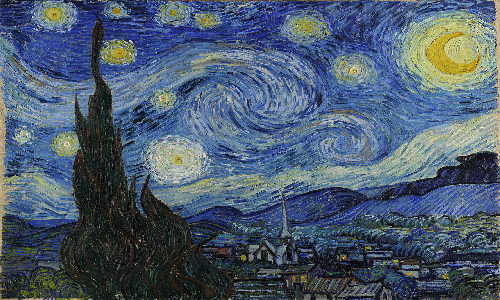

In [6]:
vangogh = load_image('img/styles/starry_night_google.jpg', (500, 300))
vangogh

## Binary Image $\to$ 4D Tensor 

To process the image by the VGG model, we need it in a 4 dimensional
tensor of the shape schema $[frame, height, width, channel]$.

*   $frame$ indexes one of several frames passing through the network
*   $channel$ indexes the _color channel_.
    *   RGB $\implies$ 3
    *   Black and White $\implies$ 1

In [7]:
# convert the binary image data to a Numpy matrix
img = image_to_matrix(vangogh)
img.shape

(1, 300, 500, 3)

In [8]:
# calculate the mean value for each channel
means = img[0].mean(axis=0).mean(axis=0)
means

array([ 76.71683,  92.3856 , 110.73184], dtype=float32)

In [9]:
# normalize the image by the means in the ImageNet data
img = normalize(img)
norm_means = img[0].mean(axis=0).mean(axis=0)
norm_means

array([  6.7928643, -24.39341  , -46.963097 ], dtype=float32)

In [10]:
# invert the means from RGB to BGR using the [::-1] 
# then subtract from the normalized means. This should
# produce the ImageNet means: [103.939, 116.779, 123.68]
means[::-1] - norm_means

array([103.93898 , 116.77901 , 123.679924], dtype=float32)

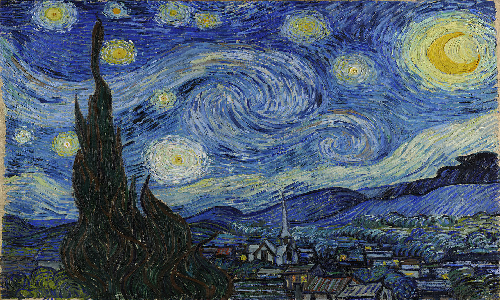

In [11]:
# validate the work by converting back to the Original
# image with no changes made
starry_night = matrix_to_image(denormalize(img[0]))
starry_night.save('tex/img/style/starry_night.png')
starry_night

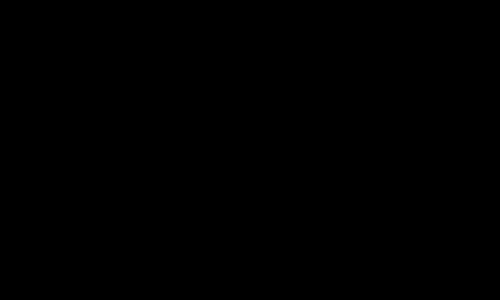

In [12]:
noise = matrix_to_image(np.random.uniform(0, 1, img.shape)[0])
noise.save('tex/img/style/noise.png')
noise

# Model

The VGG model has a few layers. Gatys et al. focus on 5 combinations their style reconstruction studies: 

1.  `block1_conv1`
1.  `block1_conv1`, `block2_conv1`
1.  `block1_conv1`, `block2_conv1`, `block3_conv1`
1.  `block1_conv1`, `block2_conv1`, `block3_conv1`, `block4_conv1`
1.  `block1_conv1`, `block2_conv1`, `block3_conv1`, `block4_conv1`, `block5_conv1`

In [13]:
VGG_19(include_top=False).output_tensors

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/R

## Gram Matrix

In [14]:
def gram(matrix):
    """
    Return a gram matrix for the given input matrix.
    
    Args:
        matrix: the matrix to calculate the gram matrix of
        
    Returns: the gram matrix of `matrix`
    """
    g = K.reshape(matrix, (matrix.shape[0] * matrix.shape[1], matrix.shape[2]))
    g = K.dot(K.transpose(g), g)
    return g

## Style Loss

In [15]:
def style_loss(style, combination):
    """
    Return the style loss between the style and combinations tensors.

    Args:
        style: the output of a layer for the style image
        combination: the output of a layer for the combination image

    Returns: the loss between `style` and `combination`
    """
    Ml = int(style.shape[0] * style.shape[1])
    Nl = int(style.shape[2])

    # take the squared euclidean distance between the gram matrices of both
    # the style and combination image. multiply by the coefficient
    return K.sum(K.square(gram(style) - gram(combination))) / (4.0 * Nl**2 * Ml**2)

## Optimizing White Noise to Reconstruct Content

In [16]:
# the learning rate for the optimization of white noise over the style domain
learning_rate = 3e2
# the number of iterations of gradient descent to perform
iterations = 50

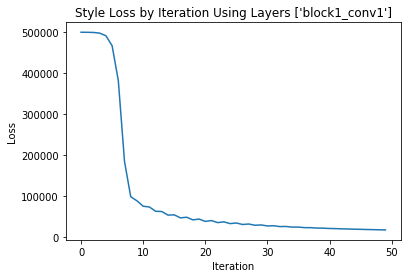

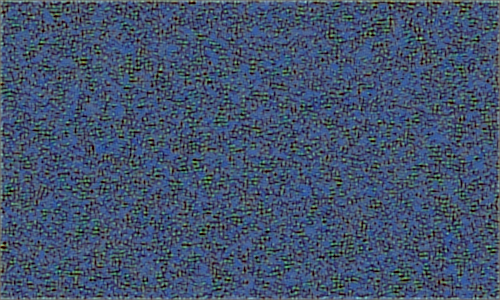

In [17]:
# load the style image into keras as a constant, it never changes
style = K.constant(img, name='Style')
# create a placeholder for the trained image, this variable trains
canvas = K.placeholder(img.shape, name='Canvas')
# combine the style and canvas tensors along the frame axis (0) 
# into a 4D tensor of shape [2, height, width, channels]
tensor = K.concatenate([style, canvas], axis=0)
# build the model with the 4D input tensor of style and canvas
model = VGG_19(include_top=False, input_tensor=tensor, pooling='avg')

layer_names = ['block1_conv1']

# initialize the loss since we need to accumulate it iteratively
loss = K.variable(0.0)

# iterate over the list of all the layers that we want to include
for layer_name in layer_names:
    # extract the layer's out that we have interest in for reconstruction
    layer = model[layer_name]
    # calculate the loss between the output of the layer on the 
    # style (0) and the canvas (1). The style loss needs to know 
    # the size of the image as well by width (shape[2]) and height
    # (shape[1])
    loss += style_loss(layer[0], layer[1])

# Gatys et al. use a w_l of 1/5 for their example with the 5 layers.
# As such, we'll simply and say for any length of layers, just take
# the average. (mirroring what they did)
loss /= len(layer_names)
    
# calculate the gradients of the model inputs with respect to 
# the loss. i.e. backpropagate the loss through the network 
# to the input layer
grads = K.gradients(loss, canvas)[0]

# generate the iteration function for gradient descent optimization
# Args:
#     noise: the input to the noise placeholder in the model
#         this effectively takes a the white noise image being
#         optimized and passes it forward and backward through 
#         the model collecting the loss and gradient along the 
#         way
# 
# Returns:
#     a tuple of (loss, gradients)
#     -   loss: the content loss between the style image
#         and the white noise
#     -   gradients: the gradients of the inputs with respect
#         to the loss
iterate = K.function([canvas], [loss, grads])

# generate random noise
noise = np.random.uniform(0, 1, img.shape)
# create a new interactive plot to visualize the loss in realtime
plot = JupyterPlot(title='Style Loss by Iteration Using Layers {}'.format(layer_names), xlabel='Iteration', ylabel='Loss')
# perform the specified iterations of gradient descent
for i in range(iterations):
    # pass the noise the canvas tensor generating the loss
    # and gradients as a tuple
    loss_i, grads_i = iterate([noise])
    # move the noise based on the gradients and learning rate
    noise -= learning_rate * grads_i
    # update the plot with the loss for this iteration
    plot(loss_i)
    
K.clear_session()

# denormalize the image to add the mean values
# of the network back and flip the channels back
# to RGB from BGR. convert this RGB matrix to 
# an image we can look at
matrix_to_image(denormalize(noise[0]))

## Functional Decomposition

In [18]:
def reconstruct_style(style: 'Image', 
                      layer_names: list=['block1_conv1'],
                      learning_rate: float=100,
                      iterations: int=100,
                      pooling: str='avg') -> 'Image':
    """
    Reconstruct the given style image at the given VGG19 layer.
    
    Args:
        style: the style image to reconstruct
        layer_names: the layers to reconstruct the style from
        learning_rate: the learning rate to optimize white noise
        iterations: the number of gradient descent iterations to perform
        pooling: the pooling style for the VGG19 network
        
    Returns:
        the reconstructed style image based on the VGG19 response
        at the given layers
    """
    # load the style image into keras as a constant, it never changes
    style = K.constant(style, name='Style')
    # create a placeholder for the trained image, this variable trains
    canvas = K.placeholder(img.shape, name='Canvas')
    # combine the style and canvas tensors along the frame axis (0) 
    # into a 4D tensor of shape [2, height, width, channels]
    tensor = K.concatenate([style, canvas], axis=0)
    # build the model with the 4D input tensor of style and canvas
    model = VGG_19(include_top=False, input_tensor=tensor, pooling=pooling)

    # initialize the loss since we need to accumulate it iteratively
    loss = K.variable(0.0)

    # iterate over the list of all the layers that we want to include
    for layer_name in layer_names:
        # extract the layer's out that we have interest in for reconstruction
        layer = model[layer_name]
        # calculate the loss between the output of the layer on the 
        # style (0) and the canvas (1). The style loss needs to know 
        # the size of the image as well by width (shape[2]) and height
        # (shape[1])
        loss += style_loss(layer[0], layer[1])

    # Gatys et al. use a w_l of 1/5 for their example with the 5 layers.
    # As such, we'll simply and say for any length of layers, just take
    # the average. (mirroring what they did)
    loss /= len(layer_names)

    # calculate the gradients of the model inputs with respect to 
    # the loss. i.e. backpropagate the loss through the network 
    # to the input layer
    grads = K.gradients(loss, canvas)[0]

    # generate the iteration function for gradient descent optimization
    # Args:
    #     noise: the input to the noise placeholder in the model
    #         this effectively takes a the white noise image being
    #         optimized and passes it forward and backward through 
    #         the model collecting the loss and gradient along the 
    #         way
    # 
    # Returns:
    #     a tuple of (loss, gradients)
    #     -   loss: the content loss between the style image
    #         and the white noise
    #     -   gradients: the gradients of the inputs with respect
    #         to the loss
    iterate = K.function([canvas], [loss, grads])

    # generate random noise
    noise = np.random.uniform(0, 1, img.shape)
    # perform the specified iterations of gradient descent
    for i in range(iterations):
        # pass the noise the canvas tensor generating the loss
        # and gradients as a tuple
        loss_i, grads_i = iterate([noise])
        # move the noise based on the gradients and learning rate
        noise -= learning_rate * grads_i

    K.clear_session()

    # denormalize the image to add the mean values
    # of the network back and flip the channels back
    # to RGB from BGR. convert this RGB matrix to 
    # an image we can look at
    return matrix_to_image(denormalize(noise[0]))

## Visualization of all 5 Gatys et al. Style Layer Sets

In [19]:
# a dictionary of some values found quickly by experimentation to
# visualize the response at each layer set. the layer names themself
# come directly from the paper.
gatys_layers = {
    'block1_conv1': (1000, 1e2),
    'block1_conv1:block2_conv1': (1000, 1),
    'block1_conv1:block2_conv1:block3_conv1': (1000, 1),
    'block1_conv1:block2_conv1:block3_conv1:block4_conv1': (1000, 1e-2),
    'block1_conv1:block2_conv1:block3_conv1:block4_conv1:block5_conv1': (1000, 1e-2)
}

['block1_conv1',
 'block2_conv1',
 'block3_conv1',
 'block4_conv1',
 'block5_conv1']

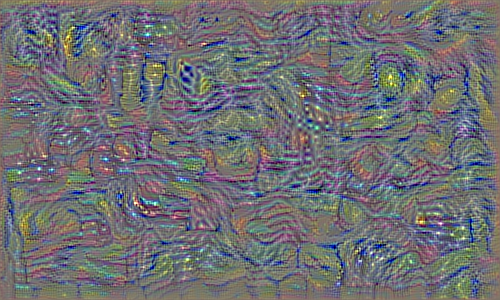

['block1_conv1', 'block2_conv1', 'block3_conv1']

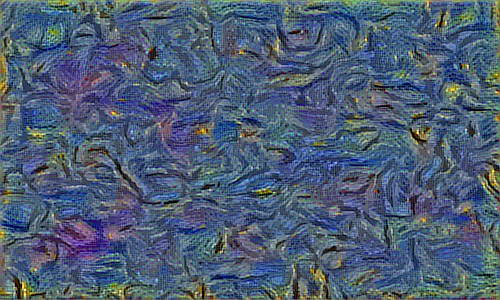

['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']

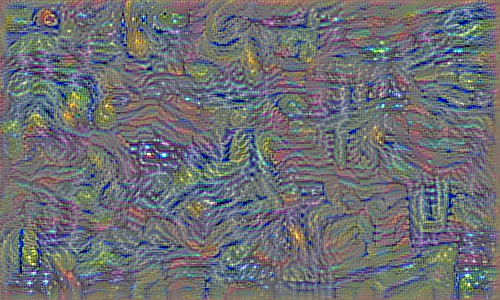

['block1_conv1']

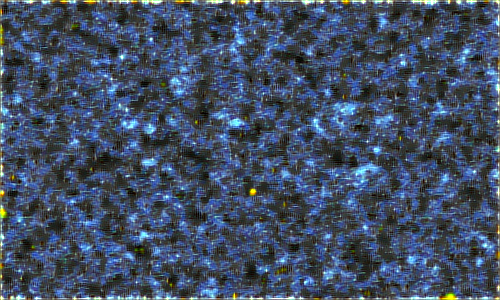

['block1_conv1', 'block2_conv1']

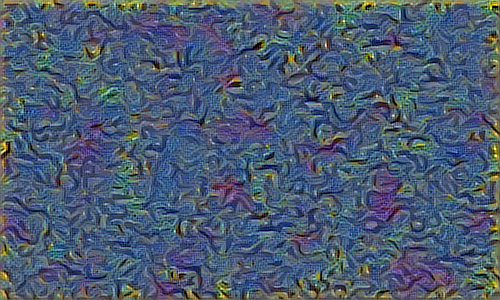

In [20]:
from IPython.display import display

# iterate over the layers and their hyperparameters
for layer_names_str, hyperparameters in gatys_layers.items():
    # split the string of layer names into lists based on
    # the colon delimitter
    layer_names = layer_names_str.split(':')
    # unpack the hyperparameters
    iterations, learning_rate = hyperparameters
    # generate a reconstructed image with the model
    rec = reconstruct_style(img, layer_names, learning_rate, iterations)
    # display the layer name
    display(layer_names)
    # display the reconstructed image
    display(rec)
    # save the image to disk
    rec.save('tex/img/style/{}.png'.format(layer_names[-1]))